In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta
from tqdm import notebook

# Spread Change Volatility by Credit Rating
## (Exhibit 1)
### trailing 36 months ('10.1.4. ~ '20.8.20.)
 
 * 36 month moving standard deviation
 * AA+, AA-, BBB+, 3 month maturity




In [6]:
def spread(rating):
    file = 'https://www.dropbox.com/scl/fi/9si4tv37ijemqwzvhek7u/credit_ytm.xlsx?dl=1&rlkey=y22k9lcfjxg9uczdelv4l0uw2'
    company = pd.read_excel(file, index_col = '기준일', sheet_name = rating)
    company.index = pd.DatetimeIndex(company.index.astype(str))
    
    del company['15Y'], company['20Y'] #나중에 데이터 확보시 삭제
    
    free = pd.read_csv('https://www.dropbox.com/s/47vnwxfj1jxni6u/bootstrap_ZCB_ytm.csv?dl=1', index_col = 'date')
    free.index = pd.DatetimeIndex(free.index.astype(str))
    
    free.columns = company.columns
    
    result = 100 * company - 10000 * free #bp 단위
    
    return result

In [7]:
triA = spread('AAA')
douAp = spread('AA+')
douA = spread('AA0')
douAm = spread('AA-')
triBp = spread('BBB+')
triB = spread('BBB0')
triBm = spread('BBB-')

In [4]:
douAp = spread('AA+')
douAm = spread('AA-')
triBp = spread('BBB+')

In [5]:
month_douAp = douAp.resample('MS').first()
month_douAm = douAm.resample('MS').first()
month_triBp = triBp.resample('MS').first()

In [6]:
a = month_douAp.rolling(36).std()
b = month_douAm.rolling(36).std()
c = month_triBp.rolling(36).std()

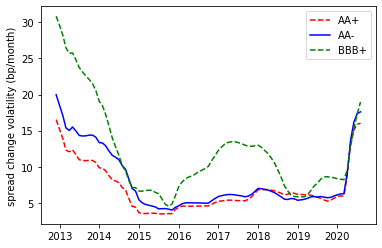

In [20]:
plt.plot(month_douAp.index, a['3M'], 'r--', month_douAm.index, b['3M'], 'b', month_triBp.index, c['3M'], 'g--')
plt.ylabel('spread change volatility (bp/month)')
plt.legend(['AA+', 'AA-', 'BBB+'])

# Spread Change Volatility by Spread Range
## (Exhibit 2) 
### trailing 36 month ('10.1.4. ~ '20.8.20.)

* investment-grade corporate universe partitioned by spread levels
* Duration matching
* Duration이 없는 경우, 만기로 대체 (만기는 issuer_data.xlsx 이용)
* applied rate가 없는 경우, intrinsic rate로 대체 - 다 없는 경우 삭제


In [21]:
def raw(year):
    name = 'price_'+str(year)+'.csv'
    dat = pd.read_csv(name, names = ['date', 'code', 'ytm', 'close', 'D', 'convexity', 
                           'applied rate', 'intrinsic rate', 'high', 'low', 'volume', 'issued price', 'issuer code'])
    dat.index = dat['date']
    del dat['date']
    
    dat.index = pd.to_datetime(dat.index.astype(str), format = '%Y-%m-%d')
    
    dat = dat.sort_values('date')
    
    return dat

In [2]:
def invest(year):
    name = 'price_'+str(year)+'.csv'
    dat = pd.read_csv(name, names = ['date', 'code', 'ytm', 'close', 'D', 'convexity', 
                           'applied rate', 'intrinsic rate', 'high', 'low', 'volume', 'issued price', 'issuer code'])
    
    dat.drop(dat[dat['applied rate'] == 'BB+'].index, inplace = True)
    dat.drop(dat[dat['applied rate'] == 'BB0'].index , inplace = True)
    dat.drop(dat[dat['applied rate'] == 'BB-'].index, inplace = True)
    dat.drop(dat[dat['applied rate'] == 'B+'].index, inplace = True)
    dat.drop(dat[dat['applied rate'] == 'B0'].index, inplace = True)
    dat.drop(dat[dat['applied rate'] == 'B-'].index, inplace = True)
    dat.drop(dat[dat['applied rate'] == 'CCC'].index, inplace = True)
    dat.drop(dat[dat['applied rate'] == 'CC'].index, inplace = True)
    dat.drop(dat[dat['applied rate'] == 'C'].index, inplace = True)
    dat.drop(dat[dat['applied rate'].isna() & dat['intrinsic rate'].isna()].index, inplace = True)
    
    dat['date'] = pd.to_datetime(dat['date'].astype(str), format = '%Y-%m-%d')
    
    return dat

In [23]:
def high_y(year):
    name = 'price_'+str(year)+'.csv'
    dat = pd.read_csv(name, names = ['date', 'code', 'ytm', 'close', 'D', 'convexity', 
                           'applied rate', 'intrinsic rate', 'high', 'low', 'volume', 'issued price', 'issuer code'])
    
    dat.drop(dat[dat['applied rate'] == 'AAA'].index, inplace = True)
    dat.drop(dat[dat['applied rate'] == 'AA+'].index , inplace = True)
    dat.drop(dat[dat['applied rate'] == 'AA0'].index, inplace = True)
    dat.drop(dat[dat['applied rate'] == 'AA-'].index, inplace = True)
    dat.drop(dat[dat['applied rate'] == 'A+'].index, inplace = True)
    dat.drop(dat[dat['applied rate'] == 'A0'].index, inplace = True)
    dat.drop(dat[dat['applied rate'] == 'A-'].index, inplace = True)
    dat.drop(dat[dat['applied rate'] == 'BBB+'].index, inplace = True)
    dat.drop(dat[dat['applied rate'] == 'BBB0'].index, inplace = True)
    dat.drop(dat[dat['applied rate'] == 'BBB-'].index, inplace = True)
    dat.drop(dat[dat['applied rate'].isna() & dat['intrinsic rate'].isna()].index, inplace = True) 
    
    dat['date'] = pd.to_datetime(dat['date'].astype(str), format = '%Y-%m-%d')
    
    dat.sort_values('date')
    
    return dat
    

In [24]:
def treasury(year):
    trea = pd.read_csv('bootstrap_ZCB_ytm.csv', index_col = 'date')
    
    trea.index = pd.to_datetime(trea.index.astype(str), format = '%Y-%m-%d') #이렇게 해놔야 밑에처럼 slicing 가능
    
    trea = trea[str(year)] 
    
    new_index = pd.date_range(str(year)+'-01-01', periods = 365)

    trea = trea.reindex(new_index.union(trea.index), method = 'ffill') #거래일이 아닌 경우 그 전 거래일 값을 가짐. 
    
    return 100*trea #소수점을 %로 표시

In [25]:
def Dmatching(data):
    info = pd.read_excel('issuer_data.xlsx')
    
    maturity_val = np.round((info['만기일']-info['발행일'])/10000)
    
    maturity = pd.Series(maturity_val.values, index = info['종목코드'])
    
    for row in notebook.tqdm(range(len(data.index))):
        if math.isnan(data['D'].iloc[row]) == True: ##데이터형
            data["D"].iloc[row] = maturity.loc[data['code'].iloc[row]]
            #전역변수 지역 변수 고려하여 최적화 해보기
            #math.nan 안에 np.nan, float.nan 이 포함됨
            
            
    if data['D'][data['D'].isna()].count() == 0: #na값이 있는지 확인
        print('변환 완료')
        
    else:
        print('변환되지 않은 값이 있습니다.')
    
    return data

In [28]:
def pivo2(indiv, trea):
   
    piv = pd.pivot_table(indiv, values = ['D', 'ytm', 'issued price'], index = ['code', 'date'])
    
    mat = []
    tn = []
    wgt = []
    
    total = sum(piv['issued price'].values)
    
    for i in notebook.tqdm(range(len(piv.index))):
        
        duration = piv["D"].loc[piv.index[i]]
        price = piv['issued price'].loc[piv.index[i]]
    
        if float(duration) <= 0:
            duration = 3
        elif float(duration) <= 1:
            duration = round(duration/0.25)*3 #분위수 개념 ()
        elif float(duration) <= 3:
            duration = round(duration/0.5)*6  #분위수 개념 ()
        elif round(float(duration)) == 6:
            duration = 60 #duration 이 반올림하여 6년이면, 5년 zcb와 matching
        elif round(float(duration)) == 8:
            duration = 84 #duration 이 반올림하여 8년이면, 7년 zcb와 matching
        elif round(float(duration)) == 9:
            duration = 120 #duration 이 반올림하여 9년이면, 10년 zcb와 matching  
        elif round(float(duration)) > 10:
            duration = 120   #duration 이 반올림하여 10년보다 크면, 10년 zcb와 matching
        else:
            duration = round(float(duration))*12 #나머진 전부 개월로 변환
        
        mat.append(duration)
        wgt.append(price/total)
    
        try:
            tn.append(trea.loc[piv.index[i][-1]]['MATURITY'+str(duration)])
        
        except Exception:
            tn.append(np.nan)
            
    piv['zcb maturity'] = mat
    piv['spread'] = piv['ytm']-tn
    piv['weight'] = wgt
    
    return piv

In [3]:
criteria = invest(2010)

In [31]:
zcb2010 = treasury(2010)

In [30]:
Dmatching(criteria)

C:\Users\belig\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)



변환 완료


,date,code,ytm,close,D,convexity,applied rate,intrinsic rate,high,low,volume,issued price,issuer code
0,2010-01-13,KR610999LW43,5.8740,10293.587045,0.919157,-10.628189,AAA,NaN,NaN,NaN,NaN,10000000000,14722
1,2010-01-13,KR3808071W42,2.6500,9935.081726,0.244975,0.120021,AAA,AAA,NaN,NaN,NaN,50000000000,03430
2,2010-01-13,KR3811041W43,2.7000,9933.864954,0.244945,0.119996,AAA,AAA,NaN,NaN,NaN,110000000000,03432
3,2010-01-13,KR3811057W44,3.9800,10087.791705,1.202266,1.774063,AAA,AAA,NaN,NaN,NaN,100000000000,03432
4,2010-01-13,KR6005991W49,4.9600,10348.041166,1.177464,1.725980,A-,NaN,NaN,NaN,NaN,20000000000,00599
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2959070,2010-12-31,KR60237820C6,4.5500,10023.399609,2.755824,8.577644,AA-,AA-,NaN,NaN,NaN,50000000000,02378
2959071,2010-12-31,KR6028822098,2.9794,10010.649862,0.221754,-0.070347,AAA,AAA,NaN,NaN,NaN,110000000000,02882
2959072,2010-12-31,KR60297810C4,4.3100,10005.821671,2.768396,8.633569,AA0,AA0,NaN,NaN,NaN,20000000000,02978
2959073,2010-12-31,KR6032391V65,1.4724,10027.401992,0.211571,-0.019545,AAA,AAA,NaN,NaN,NaN,95000000,03020


In [32]:
crit_table = pivo2(criteria, zcb2010)

# Absolute & Relative Spread Change Volatility of Investment grade universe
## (Exhibit 3) 
### trailing 36 month ('10.1.4. ~ '20.8.20.)

* moving standard deviation of 36 months

In [8]:
daily = pd.read_csv('invest_spread.csv', index_col='date')
daily.index = pd.to_datetime(daily.index)

In [9]:
month = daily.resample('MS').first()

In [10]:
absolute = []
for i in range(len(month.index)-1):
    absolute.append(month.iloc[i+1]-month.iloc[i])

absolute = pd.DataFrame(absolute)

In [11]:
absolute.loc['last'] = 1
absolute = absolute.shift(1)
absolute.index = month.index

In [12]:
abv = absolute.rolling(36).std()

In [13]:
relative = month.pct_change()*100

In [14]:
rev = relative.rolling(36).std()

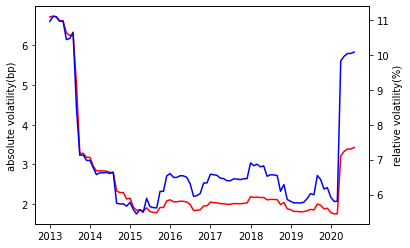

In [15]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('absolute volatility(bp)')
ax1.plot(absolute.index, abv, color = 'red')

ax2 = ax1.twinx()
ax2.set_ylabel('relative volatility(%)')
ax2.plot(relative.index, rev, color = 'blue')
plt.show()

# Average Spreads and Spread Changes for Large Issuers in the ' ' sector
# (Exhibit 5)
## (Jan 2010)

# Regression Estimates of Various Models of Spread change - Exhibit5에서 사용한 sector
# (Exhibit 6)